In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib import style
from sklearn import preprocessing
import warnings 
warnings.filterwarnings('ignore')
style.use('ggplot')

In [2]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df_train.shape

(381109, 12)

In [6]:
df_test.shape

(127037, 11)

In [10]:
df_train.describe(include = 'all')

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109,381109.000000,381109.000000,381109.000000,381109.000000,381109,381109,381109.000000,381109.000000,381109.000000,381109.000000
unique,NaN,2,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,NaN,NaN,NaN,1-2 Year,Yes,NaN,NaN,NaN,NaN
freq,NaN,206089,NaN,NaN,NaN,NaN,200316,192413,NaN,NaN,NaN,NaN
mean,190555.000000,NaN,38.822584,0.997869,26.388807,0.458210,NaN,NaN,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,NaN,15.511611,0.046110,13.229888,0.498251,NaN,NaN,17213.155057,54.203995,83.671304,0.327936
min,1.000000,NaN,20.000000,0.000000,0.000000,0.000000,NaN,NaN,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,NaN,25.000000,1.000000,15.000000,0.000000,NaN,NaN,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,NaN,36.000000,1.000000,28.000000,0.000000,NaN,NaN,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,NaN,49.000000,1.000000,35.000000,1.000000,NaN,NaN,39400.000000,152.000000,227.000000,0.000000


In [3]:
%%time
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
Wall time: 496 ms


## Data Preparation


**Categorical Feature Generating**

Ideaa here is to create a bunch of new features and later choose the best ones with **feature selection algorithm**

## Target Encodiing:-
Target encoding replaces a categorical value with the average value of the target for that value of the feature. For example , given the "Vehicla_Age" value "1-2 year" we'd calculate the average outcome (i.e, Response) for all the rows with Vehicle_Age = 1-2 year around **0.173755** 

In [3]:
cat_feats = ['Gender' , 'Vehicle_Age', 'Vehicle_Damage' ]

import category_encoders as ce 

target_enc = ce.TargetEncoder(cols = cat_feats)
target_enc.fit(df_train[cat_feats] , df_train['Response'])
train_te = target_enc.transform(df_train[cat_feats])
test_te =  target_enc.transform(df_test[cat_feats])
df_train = df_train.join(train_te.add_suffix('_target'))
df_test = df_test.join(test_te.add_suffix('_target'))

## CatBoost Encoding

This is similar to Target encoding in that it is based on the target probability for a given value, However with CatBoost, for each row, the target probability is calculated only from the row befor it

target_cbe = ce.CatBoostEncoder(cols = cat_feats)
target_cbe.fit(df_train[cat_feats] , df_train['Response'])
train_cbe = target_cbe.transform(df_train[cat_feats])
test_cbe = target_cbe.transform(df_test[cat_feats])
df_train = df_train.join(train_cbe.add_suffix('_cb'))
df_test = df_test.join(test_cbe.add_suffix('_cb'))

##  Count Encoding :-

Count Encoding replaces each categorical value with the number of times it appears in the dataset. For example, in Column "Vehicle_Damage" "Yes" comes 192413 times in the dataset then "Yes" would be replaced with the number 192413

In [4]:
count_enc = ce.CountEncoder()
count_encoded =  count_enc.fit_transform(df_train[cat_feats])
df_train = df_train.join(count_encoded.add_suffix('_count'))
count_encoded =  count_enc.fit_transform(df_test[cat_feats])
df_test = df_test.join(count_encoded.add_suffix('_count'))

In [5]:
df_test['Response'] = -1

In [24]:
df = pd.concat([df_train , df_test])
df.drop(['id' , 'Region_Code' ] ,  axis = 1, inplace = True)

In [24]:
df.shape

(508146, 19)

** Numerical Feature Generating**

Since most of the "Response" is "1" when feature value of "Vehicle_Damage" is "Yes" and "Previously_Insured" is "0" so let's combine these two columns

In [25]:
df['Damage_Uninsured'] = df['Vehicle_Damage']+"_"+df['Previously_Insured'].astype('str')

In [8]:
df.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_target,Vehicle_Age_target,Vehicle_Damage_target,Gender_count,Vehicle_Age_count,Vehicle_Damage_count,Damage_Uninsured
0,Male,44,1,0,> 2 Years,Yes,40454.0,26.0,217,1,0.138411,0.293746,0.237655,206089,16007,192413,Yes_0
1,Male,76,1,0,1-2 Year,No,33536.0,26.0,183,0,0.138411,0.173755,0.005204,206089,200316,188696,No_0
2,Male,47,1,0,> 2 Years,Yes,38294.0,26.0,27,1,0.138411,0.293746,0.237655,206089,16007,192413,Yes_0
3,Male,21,1,1,< 1 Year,No,28619.0,152.0,203,0,0.138411,0.043705,0.005204,206089,164786,188696,No_1
4,Female,29,1,1,< 1 Year,No,27496.0,152.0,39,0,0.103902,0.043705,0.005204,175020,164786,188696,No_1


The distribution of the value in "Annual_Premium" shows that most cost of Insurance is less than 100000 rupees. However, there is long tail of Annual_Premium going upto 500000 rupees . and models works better when the feature are normally distributed. To transform the Uneven distribution of Annual_Premium to normal distribution we can use the Square root and natural logarithm.


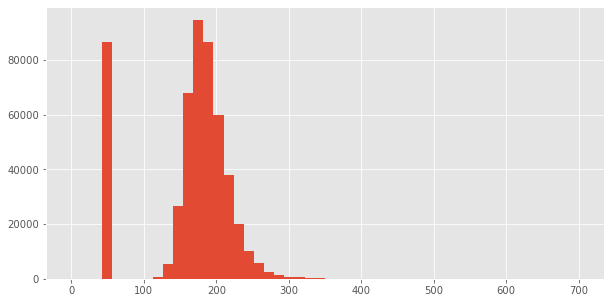

In [16]:
plt.figure(figsize=(10,5))
plt.hist(np.sqrt(df['Annual_Premium']) ,  range = (0,700) , bins = 50)
plt.show()

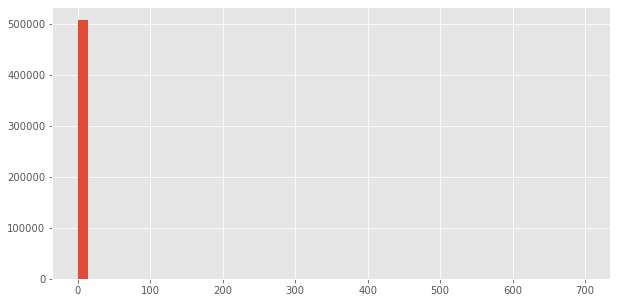

In [17]:
plt.figure(figsize=(10,5))
plt.hist(np.log(df['Annual_Premium']) ,  range = (0,700) , bins = 50)
plt.show()

The log transformation won't help our model since tree based models are scale invariant. However this should help if we had a linear network, so we will go with "squared root"

In [16]:
df['Annual_Premium_Normal'] = np.sqrt(df['Annual_Premium'].values)

In [17]:
df.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_target,Vehicle_Age_target,Vehicle_Damage_target,Gender_count,Vehicle_Age_count,Vehicle_Damage_count,Damage_Uninsured,Annual_Premium_Normal
0,Male,44,1,0,> 2 Years,Yes,40454.0,26.0,217,1,0.138411,0.293746,0.237655,206089,16007,192413,Yes_0,201.131798
1,Male,76,1,0,1-2 Year,No,33536.0,26.0,183,0,0.138411,0.173755,0.005204,206089,200316,188696,No_0,183.128370
2,Male,47,1,0,> 2 Years,Yes,38294.0,26.0,27,1,0.138411,0.293746,0.237655,206089,16007,192413,Yes_0,195.688528
3,Male,21,1,1,< 1 Year,No,28619.0,152.0,203,0,0.138411,0.043705,0.005204,206089,164786,188696,No_1,169.171511
4,Female,29,1,1,< 1 Year,No,27496.0,152.0,39,0,0.103902,0.043705,0.005204,175020,164786,188696,No_1,165.819179


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 0 to 127036
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 508146 non-null  object 
 1   Age                    508146 non-null  int64  
 2   Driving_License        508146 non-null  int64  
 3   Previously_Insured     508146 non-null  int64  
 4   Vehicle_Age            508146 non-null  object 
 5   Vehicle_Damage         508146 non-null  object 
 6   Annual_Premium         508146 non-null  float64
 7   Policy_Sales_Channel   508146 non-null  float64
 8   Vintage                508146 non-null  int64  
 9   Response               508146 non-null  int64  
 10  Gender_target          508146 non-null  float64
 11  Vehicle_Age_target     508146 non-null  float64
 12  Vehicle_Damage_target  508146 non-null  float64
 13  Gender_count           508146 non-null  int64  
 14  Vehicle_Age_count      508146 non-nu

# Converting Categorical data into numerical

def Categorical_into_Numerical(df):
    columns = df.columns.values
    
    for column in columns:
        text_digit_values = {}

        def convert_into_int(val):
            return text_digit_values[val]

        if df[column].dtype == np.object:
            column_content = df[column].values.tolist()
            unique_content = set(column_content)
            x = 0
            for unique in unique_content:
                if unique not in text_digit_values:
                    text_digit_values[unique] = x
                    x+=1

            df[column] = list(map(convert_into_int , df[column]))
    return df

df = Categorical_into_Numerical(df)
df.head()

In [29]:
col_feats = ['Gender','Driving_License','Previously_Insured','Vehicle_Damage','Damage_Uninsured','Vehicle_Age']
df = pd.get_dummies(df ,  columns = col_feats)
df.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_target,Vehicle_Age_target,Vehicle_Damage_target,Gender_count,Vehicle_Age_count,...,Previously_Insured_1,Vehicle_Damage_No,Vehicle_Damage_Yes,Damage_Uninsured_No_0,Damage_Uninsured_No_1,Damage_Uninsured_Yes_0,Damage_Uninsured_Yes_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,44,40454.0,26.0,217,1,0.138411,0.293746,0.237655,206089,16007,...,0,0,1,0,0,1,0,0,0,1
1,76,33536.0,26.0,183,0,0.138411,0.173755,0.005204,206089,200316,...,0,1,0,1,0,0,0,1,0,0
2,47,38294.0,26.0,27,1,0.138411,0.293746,0.237655,206089,16007,...,0,0,1,0,0,1,0,0,0,1
3,21,28619.0,152.0,203,0,0.138411,0.043705,0.005204,206089,164786,...,1,1,0,0,1,0,0,0,1,0
4,29,27496.0,152.0,39,0,0.103902,0.043705,0.005204,175020,164786,...,1,1,0,0,1,0,0,0,1,0


**Standardization of Nnumerical feature**

In [31]:
def Scaling_Numerical_Feature(df , num_cols):
    scaler = preprocessing.Normalizer()
    for col in num_cols:
        col_content = df[col].values
        col_content = col_content.reshape(len(df) , -1)
        scale_content = scaler.fit_transform(col_content)
        df[col] = scale_content

    return df
num_cols = ['Policy_Sales_Channel' ,'Vintage' , 'Annual_Premium', 'Age', 'Gender_count', 'Vehicle_Age_count', 'Vehicle_Damage_count' ]
df_scale = Scaling_Numerical_Feature(df ,  num_cols)
df_scale.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_target,Vehicle_Age_target,Vehicle_Damage_target,Gender_count,Vehicle_Age_count,...,Previously_Insured_1,Vehicle_Damage_No,Vehicle_Damage_Yes,Damage_Uninsured_No_0,Damage_Uninsured_No_1,Damage_Uninsured_Yes_0,Damage_Uninsured_Yes_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1.0,1.0,1.0,1.0,1,0.138411,0.293746,0.237655,1.0,1.0,...,0,0,1,0,0,1,0,0,0,1
1,1.0,1.0,1.0,1.0,0,0.138411,0.173755,0.005204,1.0,1.0,...,0,1,0,1,0,0,0,1,0,0
2,1.0,1.0,1.0,1.0,1,0.138411,0.293746,0.237655,1.0,1.0,...,0,0,1,0,0,1,0,0,0,1
3,1.0,1.0,1.0,1.0,0,0.138411,0.043705,0.005204,1.0,1.0,...,1,1,0,0,1,0,0,0,1,0
4,1.0,1.0,1.0,1.0,0,0.103902,0.043705,0.005204,1.0,1.0,...,1,1,0,0,1,0,0,0,1,0


In [32]:
df_scale.tail()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_target,Vehicle_Age_target,Vehicle_Damage_target,Gender_count,Vehicle_Age_count,...,Previously_Insured_1,Vehicle_Damage_No,Vehicle_Damage_Yes,Damage_Uninsured_No_0,Damage_Uninsured_No_1,Damage_Uninsured_Yes_0,Damage_Uninsured_Yes_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
127032,1.0,1.0,1.0,1.0,-1,0.103902,0.043705,0.005204,1.0,1.0,...,1,1,0,0,1,0,0,0,1,0
127033,1.0,1.0,1.0,1.0,-1,0.103902,0.173755,0.237655,1.0,1.0,...,0,0,1,0,0,1,0,1,0,0
127034,1.0,1.0,1.0,1.0,-1,0.138411,0.043705,0.005204,1.0,1.0,...,1,1,0,0,1,0,0,0,1,0
127035,1.0,1.0,1.0,1.0,-1,0.138411,0.173755,0.005204,1.0,1.0,...,1,1,0,0,1,0,0,1,0,0
127036,1.0,1.0,1.0,1.0,-1,0.138411,0.173755,0.005204,1.0,1.0,...,1,1,0,0,1,0,0,1,0,0


In [33]:
df_scaled_test = df_scale[df_scale['Response'] == -1]
df_scaled_train = df_scale[((df_scale['Response'] == 1) | (df_scale['Response'] == 0))]
df_scaled_test.drop(['Response'] , 1, inplace = True)

In [34]:
print(df_scaled_train.shape)
print(df_scaled_test.shape)

(381109, 26)
(127037, 25)


In [35]:
x_feature = df_scaled_train.drop(['Response'] , 1 )
y_response = df_scaled_train['Response']

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

x_train ,x_val , y_train, y_val = train_test_split(x_feature, y_response, test_size = 0.2)

log_clf = LogisticRegression()
log_clf.fit(x_train , y_train)

y_pred = log_clf.predict(x_val)

roc_auc_score(y_val , y_pred)

0.5

Let's find out which feature is important for the predicting the value,
we will be using **sklearn.feature_selection's RFECV**

In [34]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# creating model
tree_clf = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits = 5 ,  random_state=0)

clf = RFECV(tree_clf , step = 1, cv=cv, scoring='roc_auc' , n_jobs=-1)
clf.fit(x_train, y_train)

Wall time: 3min 27s


RFECV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
      estimator=DecisionTreeClassifier(), n_jobs=-1, scoring='roc_auc')

In [35]:
clf.n_features_

3

In [50]:
ranking = {}
for rank , column in zip(clf.ranking_.tolist() , x_train.columns.values):
    ranking[column] = rank

In [51]:
ranking

{'Gender': 8,
 'Age': 2,
 'Driving_License': 12,
 'Previously_Insured': 17,
 'Vehicle_Age': 11,
 'Vehicle_Damage': 16,
 'Annual_Premium': 1,
 'Policy_Sales_Channel': 3,
 'Vintage': 1,
 'Gender_target': 4,
 'Vehicle_Age_target': 9,
 'Vehicle_Damage_target': 14,
 'Gender_cb': 6,
 'Vehicle_Age_cb': 10,
 'Vehicle_Damage_cb': 15,
 'Gender_count': 5,
 'Vehicle_Age_count': 7,
 'Vehicle_Damage_count': 13,
 'Damage_Uninsured': 1}

In [21]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# creating model and parameter
tree_clf = DecisionTreeClassifier()
max_depth = [10,15,20,25]
max_feature = ['sqrt' , 'log2']
grid = dict(max_depth = max_depth , max_features = max_feature)
cv = StratifiedKFold(n_splits = 5 ,  random_state=0)

clf = GridSearchCV(estimator=tree_clf , param_grid=grid , n_jobs = -1, cv = cv, scoring = 'roc_auc', error_score = 0)
clf_result = clf.fit(x_train, y_train)

#summarize result
print('Best: %f using %s'%(clf_result.best_score_ , clf_result.best_params_))
means  = clf_result.cv_results_['mean_test_score']
stds = clf_result.cv_results_['std_test_score']
params = clf_result.cv_results_['params']

for mean , stdev, param  in zip(means , stds , params):
    print('%f (%f) with : %r'%(mean, stdev, param))

Best: 0.842866 using {'max_depth': 10, 'max_features': 'sqrt'}
0.842866 (0.001615) with : {'max_depth': 10, 'max_features': 'sqrt'}
0.841655 (0.001196) with : {'max_depth': 10, 'max_features': 'log2'}
0.825246 (0.003352) with : {'max_depth': 15, 'max_features': 'sqrt'}
0.827074 (0.003228) with : {'max_depth': 15, 'max_features': 'log2'}
0.779491 (0.011616) with : {'max_depth': 20, 'max_features': 'sqrt'}
0.777437 (0.006865) with : {'max_depth': 20, 'max_features': 'log2'}
0.724811 (0.012386) with : {'max_depth': 25, 'max_features': 'sqrt'}
0.722041 (0.006560) with : {'max_depth': 25, 'max_features': 'log2'}
Wall time: 19.4 s


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Creating model and parameter
rfc = RandomForestClassifier()
n_estimetors = [100,200,300,400,500]
max_depth = [10]
max_features = ['sqrt']
grid = dict(n_estimators = n_estimetors, max_depth = max_depth, max_features = max_features)
cv = StratifiedShuffleSplit(n_splits=10 , random_state=0)
grid_search = GridSearchCV(estimator = rfc, param_grid = grid, n_jobs = -1, scoring = 'roc_auc' , cv = cv)
grid_result = grid_search.fit(x_train , y_train)

# summarize result
print('Best result {} using: {}'.format(grid_result.best_score_ , grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean , stdev , param in zip(means , stds,params):
    print("'%f (%f) with : %r'%(mean, stdev, param)")

Best result 0.8526336050475308 using: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
'%f (%f) with : %r'%(mean, stdev, param)
'%f (%f) with : %r'%(mean, stdev, param)
'%f (%f) with : %r'%(mean, stdev, param)
'%f (%f) with : %r'%(mean, stdev, param)
'%f (%f) with : %r'%(mean, stdev, param)


In [29]:
model = grid_result.best_estimator_

In [30]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict(x_val)
roc_auc_score(y_val , y_pred)


0.5007254112201619

In [36]:
x_train_drop =  x_train.drop(['Annual_Premium' ,'Vehicle_Damage' ],1)
x_val_drop = x_val.drop(['Annual_Premium' ,'Vehicle_Damage'],1)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rfc = RandomForestClassifier(n_estimators=500 , max_depth = 10 , max_features = 'sqrt')

rfc.fit(x_train , y_train)

y_pred = rfc.predict(x_val)
roc_auc_score(y_val ,y_pred )

0.5

In [68]:
sub_sample = pd.read_csv('./dataset/sample_submission.csv')

In [69]:
y_pred = tree_clf.predict(df_scaled_test.values)

In [70]:
sub_sample['Response'] = y_pred

In [71]:
sub_sample.to_csv('./dataset/sample_sub1.0.csv', index = False)